# 01 Modelacao - Apartment (Quick)

Objetivo: treino rápido com LightGBM com configurações default.


## Setup e leitura


In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from datetime import datetime
from config import paths


In [ ]:
train_path = paths.CURATED / 'apartment_train.parquet'
valid_path = paths.CURATED / 'apartment_valid.parquet'
if not train_path.exists() or not valid_path.exists():
    raise FileNotFoundError(
        'Dados não encontrados. Executa notebooks/eda/01_data_understanding_apartment.ipynb.'
    )
df_train = pd.read_parquet(train_path)
df_valid = pd.read_parquet(valid_path)
df_train.shape, df_valid.shape


((32853, 10), (8214, 10))

## Preparar features


In [4]:
def prepare_xy(df):
    df_model = df.copy()
    df_model['log_price'] = np.log1p(df_model['Price'])

    features = [
        'LivingArea',
        'TotalArea',
        'NumberOfBathrooms',
        'Parking',
        'PropertyAge',
        'District',
        'City',
        'Town',
    ]

    target = 'log_price'
    cat_cols = ['District', 'City', 'Town']

    X = df_model[features].copy()
    y = df_model[target].copy()

    for c in cat_cols:
        X[c] = X[c].astype('category')

    return X, y, features, cat_cols

X_train, y_train, FEATURES, cat_cols = prepare_xy(df_train)
X_valid, y_valid, _, _ = prepare_xy(df_valid)


## Treino


In [ ]:
import lightgbm as lgb

params = {
    'n_estimators': 2000,
    'learning_rate': 0.03,
    'num_leaves': 63,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
}

model = lgb.LGBMRegressor(**params)

model.fit(
    X_train, y_train,
    categorical_feature=cat_cols,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_names=['train', 'valid'],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)]
)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 32853, number of used features: 8
[LightGBM] [Info] Start training from score 12.623518
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.20426	train's l2: 0.0417223	valid's rmse: 0.226989	valid's l2: 0.051524
[200]	train's rmse: 0.180425	train's l2: 0.0325531	valid's rmse: 0.210284	valid's l2: 0.0442193
[300]	train's rmse: 0.171581	train's l2: 0.0294401	valid's rmse: 0.205704	valid's l2: 0.0423141
[400]	train's rmse: 0.165394	train's l2: 0.0273553	valid's rmse: 0.202755	valid

,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.03
,n_estimators,2000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Treino vs validacao

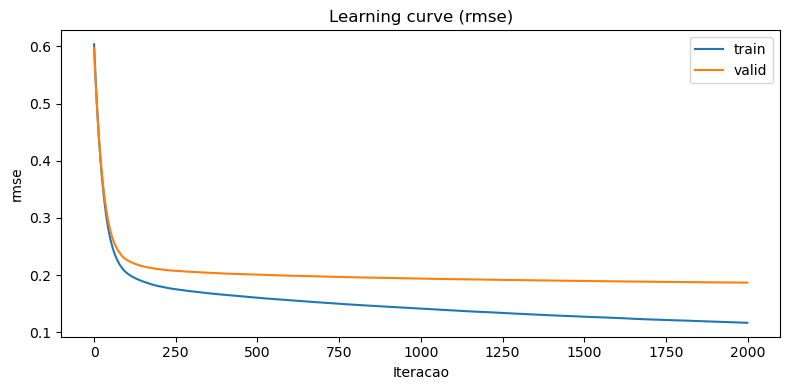

In [6]:
evals = model.evals_result_
metric = list(evals['train'].keys())[0]

plt.figure(figsize=(8, 4))
plt.plot(evals['train'][metric], label='train')
plt.plot(evals['valid'][metric], label='valid')
plt.title(f'Learning curve ({metric})')
plt.xlabel('Iteracao')
plt.ylabel(metric)
plt.legend()
plt.tight_layout()
plt.show()


## Avaliacao


In [7]:
pred_log = model.predict(X_valid)
pred = np.expm1(pred_log)
true = np.expm1(y_valid)

from sklearn.metrics import mean_absolute_error, root_mean_squared_error

rmse = root_mean_squared_error(true, pred)
mae = mean_absolute_error(true, pred)
mape = (np.abs(true - pred) / true).mean() * 100

metrics = {'rmse': rmse, 'mae': mae, 'mape': mape}
metrics


{'rmse': 106783.58679592774,
 'mae': 48393.112713347786,
 'mape': np.float64(12.843590781417232)}

## Guardar modelo e métricas

WindowsPath('C:/denv_testes/pt-real-estate-deal-engine/experiments/apartment/lgbm/run_20260102_223020/plots/learning_curve.png')

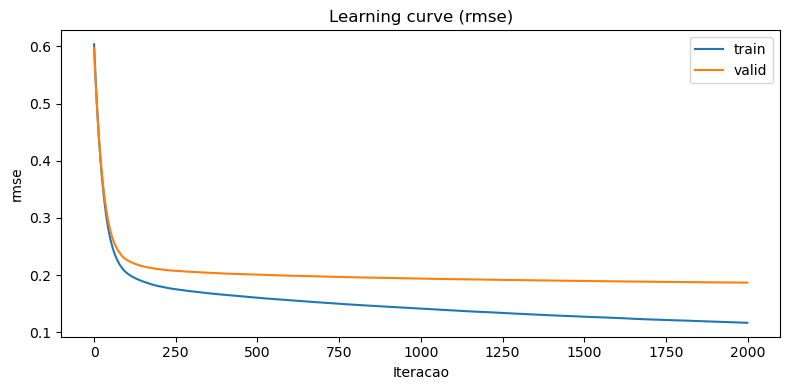

In [8]:
run_id = datetime.now().strftime('%Y%m%d_%H%M%S')
run_dir = paths.EXPERIMENTS / 'apartment' / 'lgbm' / f'run_{run_id}'
plots_dir = run_dir / 'plots'
run_dir.mkdir(parents=True, exist_ok=True)
plots_dir.mkdir(parents=True, exist_ok=True)

# Guardar modelo por corrida
run_model_path = run_dir / 'model.pkl'
joblib.dump({'model': model, 'features': FEATURES, 'cat_cols': cat_cols}, run_model_path)

# Guardar modelo baseline na raiz
root_model_path = paths.MODELS / 'apartment_lgbm.pkl'
root_model_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump({'model': model, 'features': FEATURES, 'cat_cols': cat_cols}, root_model_path)

# Guardar metricas e params
(run_dir / 'metrics.json').write_text(json.dumps(metrics, indent=2), encoding='utf-8')
(run_dir / 'params.json').write_text(json.dumps(params, indent=2), encoding='utf-8')

# Guardar curva de treino
plot_path = plots_dir / 'learning_curve.png'
plt.figure(figsize=(8, 4))
plt.plot(evals['train'][metric], label='train')
plt.plot(evals['valid'][metric], label='valid')
plt.title(f'Learning curve ({metric})')
plt.xlabel('Iteracao')
plt.ylabel(metric)
plt.legend()
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
plot_path


## Feature importance


In [ ]:
fi = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=False)
fi

TotalArea            33863
LivingArea           33722
PropertyAge          29118
Town                  8991
NumberOfBathrooms     7055
City                  4861
Parking               4785
District              1605
dtype: int32